# Regression Script
## Random Forest

### Florian Beyer
### 2020-02-22

Quelle: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb

In [31]:
# Requried Packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import pandas as pd # handling large data as table sheets

from sklearn.ensemble import RandomForestRegressor

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict

#from sklearn.ensemble import AdaBoostRegressor
#from sklearn import svm
#from sklearn.kernel_ridge import KernelRidge
#from sklearn.model_selection import GridSearchCV
#from sklearn.cross_decomposition import PLSRegression
#from sklearn.gaussian_process import GaussianProcessRegressor

from joblib import dump, load

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()



In [32]:
# data input

# define a number of trees that should be used (default = 500)
est = 1000

# muss noch erklaert werden
randomState = 111


# the remote sensing image you want to classify
img_RS = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Daten\\stack_all_data_tif.tif'

# training and validation
#    as image in the same extand as your remote sensing image
#    no data pixels = 0 or negative
#    class pixels > 0 and as integer
field = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Daten\\biomasse_all.shp'


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'FM_in_Gram'


# save path, predicted image
#prediction_map = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\prediction_map_20200222.tif'


# save path, trained model
#save_model = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\RFR_20200222.joblib'


In [33]:
# Data preparation

# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [34]:
# Data preparation
# load training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()
mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()


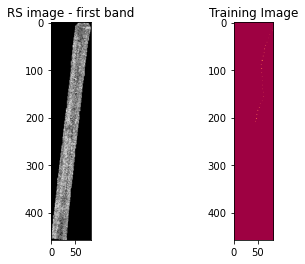

In [35]:
# Display image and Training data

plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()


In [36]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('We have {n} training samples'.format(n=n_samples))# Subset the image dataset with the training image = X



We have 25 training samples


In [37]:
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

In [38]:
features = pd.DataFrame(X)

In [39]:
band_names = []
for i in range(X.shape[1]):
#for i in range(0,2500):
    nband = "Band_"+ str(i+1)
    band_names.append(nband)

features.columns = band_names

In [40]:
print('The shape of our features is:', features.shape)
print('The number of Spectra is:', features.shape[0])
print('The number of bands is:', features.shape[1])

The shape of our features is: (25, 19)
The number of Spectra is: 25
The number of bands is: 19


In [41]:
features['FM'] = y

In [42]:
# Labels are the values we want to predict
labels = np.array(features['FM'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('FM', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [43]:
scaler = MinMaxScaler(feature_range=(0,1))
features = scaler.fit_transform(features)

In [44]:
RFR = RandomForestRegressor(bootstrap=True,
                             criterion='mse',
                             max_depth=None,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             min_weight_fraction_leaf=0.0,
                             n_estimators=est,
                             n_jobs=-1, # using all cores
                             oob_score=True,
                             random_state=False,
                             verbose=1,
                             warm_start=False)

In [45]:
RFR.fit(features, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.2s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=True,
                      random_state=False, verbose=1, warm_start=False)

In [46]:
scores = cross_val_score(RFR, features, labels, cv=10, scoring='neg_mean_absolute_error')
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks     

array([ -45.11666667,  -68.50666667, -190.25666667,  -86.28333333,
        -67.80666667,  -18.535     ,  -35.51      ,  -49.64      ,
       -169.485     , -152.245     ])

In [57]:
scores3 = cross_val_score(RFR, features, labels, cv=3)
scores3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks     

array([0.35210325, 0.31034001, 0.50593484])

In [47]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -88.34 (+/- 114.72)


In [53]:
scores2 = cross_val_predict(RFR, features, labels, cv=2)
scores2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks     

array([158.95, 179.89, 163.77, 171.26, 217.88, 340.74, 390.08, 339.24,
       373.22, 287.27, 420.83, 356.14, 294.97, 176.95, 197.65, 136.58,
       162.79, 160.33, 157.87, 192.53, 266.64, 335.44, 547.53, 485.5 ,
       400.19])

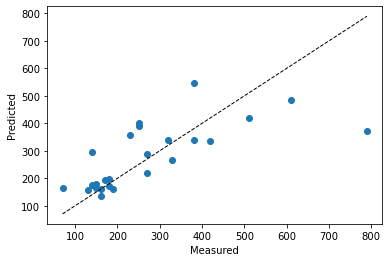

Mean squared error: 13509.53
Coefficient of determination: 0.50


In [54]:
fig,ax = plt.subplots()
ax.scatter(y,scores2)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print('Mean squared error: %.2f'
      % mean_squared_error(y, scores2))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, scores2))

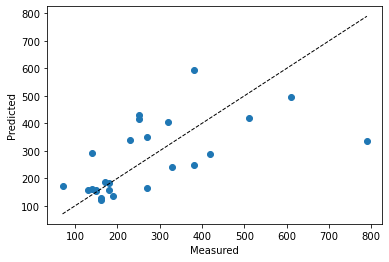

Mean squared error: 18191.78
Coefficient of determination: 0.33


In [30]:
fig,ax = plt.subplots()
ax.scatter(y,RFR.oob_prediction_)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print('Mean squared error: %.2f'
      % mean_squared_error(y, RFR.oob_prediction_))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, RFR.oob_prediction_))

In [56]:
from sklearn.model_selection import ShuffleSplit
n_samples = features.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
cross_val_score(RFR, features, labels, cv=cv)

array([ 0.06695375, -0.90513192,  0.15758065,  0.48878232,  0.20480742])

In [32]:
cv = StratifiedKFold(n_splits=2, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(features, labels), range(2)):
    RFR.fit(features, labels)
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

C:\Users\LenoFlo\Anaconda2\envs\py3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


NameError: name 'compute_roc_auc' is not defined

In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    RFR.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [277]:
RFR.score(train_features, train_labels)

0.8935593344353523

In [278]:
# Use the forest's predict method on the test data
predictions_test_ds = RFR.predict(test_features)

In [279]:
# Calculate the absolute errors
errors = abs(predictions_test_ds - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'gramms.')


Mean Absolute Error: 71.05 gramms.


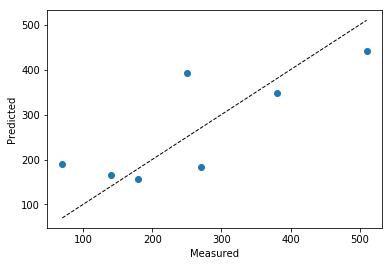

In [280]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions_test_ds)
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

In [281]:
print('Mean squared error: %.2f'
      % mean_squared_error(test_labels, predictions_test_ds))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_labels, predictions_test_ds))


Mean squared error: 7003.65
Coefficient of determination: 0.63


[278.92957746 185.14511873 192.27777778 189.51566952 179.16184971
 456.75287356 390.20172911 463.04812834 178.3625731  241.5451895
 402.18130312 330.23560209 155.17857143 593.64640884 168.79551821
 286.27249357 167.61363636 328.91364903]
[420.0, 170.0, 180.0, 330.0, 150.0, 320.0, 250.0, 610.0, 130.0, 190.0, 230.0, 790.0, 160.0, 380.0, 150.0, 140.0, 160.0, 270.0]


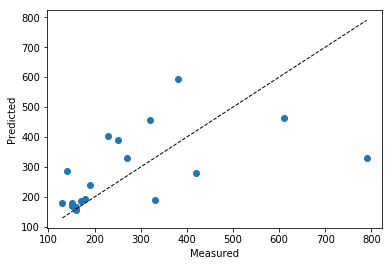

In [282]:
pred1 = np.array(RFR.oob_prediction_)
obs = np.array(train_labels)
obs = [np.float(i) for i in obs]

print(pred1)
print(obs)

fig,ax = plt.subplots()
ax.scatter(obs,pred1)
ax.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [283]:
print('Mean squared error: %.2f'
      % mean_squared_error(obs, pred1))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(obs, pred1))

Mean squared error: 23210.63
Coefficient of determination: 0.23
